In [22]:
using SparseArrays: spdiagm
import Statistics; stat = Statistics;

# todo: .=
# todo: initialization
# todo: put driver in a function

In [23]:
nx = 40           # number of grid points in x direction (P-grid)
ny = 60           # number of grid points in the y direction (P-grid)
Lx = 1.0          # domain length in x
Ly = 1.5          # domain length in y
ν  = 1.0          # kinematic viscosity
    
ubc_t = 10.0      # u on top boundary
ubc_b = 0.0       # u on bottom boundary
vbc_r = 10.0      # v on right boundary
vbc_l = 0.0       # v on left boundary
    
n_τ_run = 2       # number of box timescales to run for
cfl  = 0.05       # timestep size factor

#---------------------------------------------

x  = collect(range(0,stop=Lx,length=nx))  # x-grid
y  = collect(range(0,stop=Ly,length=ny))  # y-grid
Δx = x[2] - x[1]     # x-grid spacing
Δy = y[2] - y[1]     # y-grid spacing

τ_box  = (Lx+Ly)/2 / maximum(abs.([ubc_t, ubc_b, vbc_r, vbc_l]))      # box timescale
tend   = τ_box * n_τ_run                                               # simulation run time
Δt     = cfl*minimum([Δx,Δy])/maximum(abs.([ubc_t,ubc_b,vbc_r,vbc_l])) # timestep size
nsteps = trunc(Int,tend/Δt)                                                  # number of timesteps
Δt     = tend/nsteps                                                   # timestep size
    
#-------------------- set solution variables
    
u = zeros(nx+1,ny)
v = zeros(nx,ny+1)               
P = zeros(nx,ny);                # P = P/ρ (P_hat)

In [24]:
"""
ue, uw, un, us, vn, vs are values on u-cell faces.
These arrays include ALL u-cells (nx+1,ny) for convenience,
but only interior u-cells (and corresponding face values) are set.
"""
function get_Hu()
    
    ue   = zeros(nx+1,ny)    # todo: empty Matrix{Float64}(undef, nx+1, ny)
    uw   = Array{Float64}(undef, (nx+1,ny))
    un   = Array{Float64}(undef, (nx+1,ny))
    us   = Array{Float64}(undef, (nx+1,ny))
    vn   = Array{Float64}(undef, (nx+1,ny))
    vs   = Array{Float64}(undef, (nx+1,ny))
    τxxe = Array{Float64}(undef, (nx+1,ny))
    τxxw = Array{Float64}(undef, (nx+1,ny))
    τxyn = Array{Float64}(undef, (nx+1,ny))
    τxys = Array{Float64}(undef, (nx+1,ny))
    Hu   = Array{Float64}(undef, (nx+1,ny))
    
    i = range(2, stop=nx)              # u-cell centers in domain interior
    
    @. ue[i,:] = (u[i+1,:] + u[i,:])/2
    @. uw[i,:] = (u[i,:]    + u[i-1,:])/2
    
    j = range(1, stop=ny-1)
    @. un[i,j] = (u[i,j+1] + u[i,j])/2
    @. un[i,ny] = ubc_t
    j = range(2, stop=ny)
    @. us[i,j] = (u[i,j] + u[i,j-1])/2
    @. us[i,1] = ubc_b
    
    j = range(1, stop=ny)
    @. vn[i,j] = (v[i-1,j+1] + v[i,j+1])/2
    @. vs[i,j] = (v[i-1,j]   + v[i,j])  /2
    
    @. τxxe[i,:] = -2*ν*(u[i+1,:] - u[i,:])  /Δx
    @. τxxw[i,:] = -2*ν*(u[i,:]   - u[i-1,:])/Δx
    
    j = range(1, stop=ny-1)
    @. τxyn[i,j]  = -ν*(u[i,j+1]-u[i,j])/Δy   - ν*(v[i,j+1] -v[i-1,j+1])/Δx
    @. τxyn[i,ny] = -ν*(ubc_t-u[i,ny])/(Δy/2) - ν*(v[i,ny+1]-v[i-1,ny+1])/Δx 
    
    j = range(2, stop=ny)
    @. τxys[i,j] = -ν*(u[i,j]-u[i,j-1])/Δy  - ν*(v[i,j]-v[i-1,j])/Δx
    @. τxys[i,1] = -ν*(u[i,1]-ubc_b)/(Δy/2) - ν*(v[i,1]-v[i-1,1])/Δx
    
    @. Hu[i,:] =  -((ue[i,:]*ue[i,:] - uw[i,:]*uw[i,:])/Δx + (un[i,:]*vn[i,:] - us[i,:]*vs[i,:])/Δy) -
                   ((τxxe[i,:] - τxxw[i,:])/Δx + (τxyn[i,:] - τxys[i,:])/Δy)
    
    return Hu
end;


In [25]:
"""
vn, vs, ve, vw, ue, uw are values on v-cell faces
These arrays include ALL v-cells (nx,ny+1) for convenience,
but only interior v-cells (and corresponding face values) are set.
"""
function get_Hv()
    
    vn   = Array{Float64}(undef, (nx,ny+1))   
    vs   = Array{Float64}(undef, (nx,ny+1))
    ve   = Array{Float64}(undef, (nx,ny+1))
    vw   = Array{Float64}(undef, (nx,ny+1))
    ue   = Array{Float64}(undef, (nx,ny+1))
    uw   = Array{Float64}(undef, (nx,ny+1))
    τyyn = Array{Float64}(undef, (nx,ny+1))
    τyys = Array{Float64}(undef, (nx,ny+1))
    τyxe = Array{Float64}(undef, (nx,ny+1))
    τyxw = Array{Float64}(undef, (nx,ny+1))
    Hv   = Array{Float64}(undef, (nx,ny+1))
    
    j = range(2, stop=ny)              # v-cell centers in domain interior
    
    @. vn[:,j] = (v[:,j+1] + v[:,j])/2
    @. vs[:,j] = (v[:,j]   + v[:,j-1])/2
    
    i = range(1, stop=nx-1)
    @. ve[i,j]  = (v[i+1,j] + v[i,j])/2
    @. ve[nx,j] = vbc_r
    i = range(2, stop=nx)
    @. vw[i,j] = (v[i,j] + v[i-1,j])/2
    @. vw[1,j] = vbc_l
    
    i = range(1, stop=nx)
    @. ue[i,j] = (u[i+1,j-1] + u[i+1,j])/2
    @. uw[i,j] = (u[i,j-1]   + u[i,j])  /2
    
    @. τyyn[:,j] = -2*ν*(v[:,j+1] - v[:,j])  /Δy
    @. τyys[:,j] = -2*ν*(v[:,j]   - v[:,j-1])/Δy
    
    i = range(1, stop=nx-1)
    @. τyxe[i,j]  = -ν*(v[i+1,j]-v[i,j])/Δx   - ν*(u[i+1,j] -u[i+1,j-1])/Δy
    @. τyxe[nx,j] = -ν*(vbc_r-v[nx,j])/(Δx/2) - ν*(u[nx+1,j]-u[nx+1,j-1])/Δy 
    
    i = range(2, stop=nx)
    @. τyxw[i,j] = -ν*(v[i,j]-v[i-1,j])/Δx  - ν*(u[i,j]-u[i,j-1])/Δy
    @. τyxw[1,j] = -ν*(v[1,j]-vbc_l)/(Δx/2) - ν*(u[1,j]-u[1,j-1])/Δy
    
    @. Hv[:,j] =  -((vn[:,j]*vn[:,j] - vs[:,j]*vs[:,j])/Δy + (ve[:,j]*ue[:,j] - vw[:,j]*uw[:,j])/Δx) -
                   ((τyyn[:,j] - τyys[:,j])/Δy + (τyxe[:,j] - τyxw[:,j])/Δx)
    
    return Hv
end;

In [34]:
using LinearAlgebra: lu
"""
Set up and solve the AP=b system, where A is a matrix, P (=Phat) and b are vectors.
"""
function solve_P(h, Hu, Hv)
    
    nP = nx*ny     # total grid points solved (all P-grid cells)
    
    b    = zeros(nx,ny)          # set below
    cP   = zeros(nx,ny)          # coefficient of P_i,j; set below
    cPjm = fill(-h*Δx/Δy, nx,ny) # coefficient of P_i,j-1; initialized here, specialized below
    cPim = fill(-h*Δy/Δx, nx,ny) # coefficient of P_i-1,j; initialized here, specialized below
    cPip = fill(-h*Δy/Δx, nx,ny) # coefficient of P_i+1,j; initialized here, specialized below
    cPjp = fill(-h*Δx/Δy, nx,ny) # coefficient of P_i,j+1; initialized here, specialized below
    
    #-------------------- 
    
    # Interior
    i = range(2, stop=nx-1); j = range(2, stop=ny-1)
    @. b[i,j]   = -Δy*(u[i+1,j]+h*Hu[i+1,j])  + Δy*(u[i,j]+h*Hu[i,j]) - Δx*(v[i,j+1]+h*Hv[i,j+1]) + Δx*(v[i,j]+h*Hv[i,j])
    @. cP[i,j]  =  2*h*Δy/Δx + 2*h*Δx/Δy
    
    # Corner bottom left
    i = 1; j = 1
    b[i,j]    = -Δy*(u[i+1,j]+h*Hu[i+1,j])      + Δy*u[i,j]               - Δx*(v[i,j+1]+h*Hv[i,j+1])     + Δx*v[i,j]
    cP[i,j]   =  h*Δy/Δx + h*Δx/Δy
    cPjm[i,j] =  0.0
    cPim[i,j] =  0.0
    
    # Side bottom
    i = range(2, stop=nx-1); j = 1
    @. b[i,j]    = -Δy*(u[i+1,j]+h*Hu[i+1,j]) + Δy*(u[i,j]+h*Hu[i,j]) - Δx*(v[i,j+1]+h*Hv[i,j+1]) + Δx*v[i,j]
    @. cP[i,j]   =  2*h*Δy/Δx + h*Δx/Δy
    @. cPjm[i,j] =  0.0
    
    # Corner bottom right
    i = nx; j = 1
    b[i,j]    = -Δy*u[i+1,j]                    + Δy*(u[i,j]+h*Hu[i,j])   - Δx*(v[i,j+1]+h*Hv[i,j+1])     + Δx*v[i,j]
    cP[i,j]   =  h*Δy/Δx + h*Δx/Δy
    cPjm[i,j] =  0.0
    cPip[i,j] =  0.0
    
    # Side left
    i = 1; j = range(2, stop=ny-1)
    @. b[i,j]    = -Δy*(u[i+1,j]+h*Hu[i+1,j]) + Δy*u[i,j]              - Δx*(v[i,j+1]+h*Hv[i,j+1]) + Δx*(v[i,j]+h*Hv[i,j])
    @. cP[i,j]   =  h*Δy/Δx + 2*h*Δx/Δy
    @. cPim[i,j] =  0.0
    
    # Side right
    i = nx; j = range(2, stop=ny-1)
    @. b[i,j]    = -Δy*u[i+1,j]                 + Δy*(u[i,j]+h*Hu[i,j]) - Δx*(v[i,j+1]+h*Hv[i,j+1]) + Δx*(v[i,j]+h*Hv[i,j])
    @. cP[i,j]   =  h*Δy/Δx + 2*h*Δx/Δy
    @. cPip[i,j] =  0.0
    
    # Corner top left
    i = 1; j  = ny
    b[i,j]    = -Δy*(u[i+1,j]+h*Hu[i+1,j])      + Δy*u[i,j]               - Δx*v[i,j+1]                   + Δx*(v[i,j]+h*Hv[i,j])
    cP[i,j]   =  h*Δy/Δx + h*Δx/Δy
    cPim[i,j] =  0.0
    cPjp[i,j] =  0.0
    
    # Side top
    i = range(2, stop=nx-1); j = ny
    @. b[i,j]    = -Δy*(u[i+1,j]+h*Hu[i+1,j]) + Δy*(u[i,j]+h*Hu[i,j]) - Δx*v[i,j+1]                 + Δx*(v[i,j]+h*Hv[i,j])
    @. cP[i,j]   =  2*h*Δy/Δx + h*Δx/Δy
    @. cPjp[i,j] =  0.0
    
    # Corner top right
    i = nx; j = ny
    b[i,j]    = -Δy*u[i+1,j]                    + Δy*(u[i,j]+h*Hu[i,j])   - Δx*v[i,j+1]                   + Δx*(v[i,j]+h*Hv[i,j])
    cP[i,j]   =  h*Δy/Δx + h*Δx/Δy
    cPip[i,j] =  0.0
    cPjp[i,j] =  0.0
    
    #---------------------------------
    
    b    = reshape(b,    nP)
    
    cP   = reshape(cP,   nP)
    cPjm = reshape(cPjm, nP)
    cPim = reshape(cPim, nP)
    cPip = reshape(cPip, nP)
    cPjp = reshape(cPjp, nP)
    
    A = spdiagm(-nx=>cPjm[nx+1:end], -1=>cPim[2:end], 0=>cP, 1=>cPip[1:end-1], nx=>cPjp[1:end-nx])
    #LU = lu(A)
    
    #---------------------------------
    
    P = A\b
    
    P .-= stat.mean(P)
    
    P = reshape(P, nx,ny)
    
    return P
end;    

In [35]:
@elapsed begin

ke = zeros(nsteps+1)
times = range(0, stop=tend, length=nsteps+1)
 
for k in 1:nsteps
    
    Hu = get_Hu()
    Hv = get_Hv()
    
    P .= solve_P(Δt, Hu, Hv)
    
    i = range(2, stop=nx)
    @. u[i,:] = u[i,:] + Δt*Hu[i,:] - Δt*(P[i,:]-P[i-1,:])/Δx
    
    j = range(2, stop=ny)
    @. v[:,j] = v[:,j] + Δt*Hv[:,j] - Δt*(P[:,j]-P[:,j-1])/Δy
    
    #----------- interpolate velocities to the P-grid
    
    U = (u[1:end-1,:] .+ u[2:end,:])/2
    V = (v[:,1:end-1] .+ v[:,2:end])/2
    velmag = sqrt.(U.*U + V.*V)
    ke[k+1] = 0.5*(stat.mean(velmag.^2))
end
    
U = (u[1:end-1,:] .+ u[2:end,:])/2
V = (v[:,1:end-1] .+ v[:,2:end])/2
velmag = sqrt.(U.*U + V.*V);
end

11.641838457

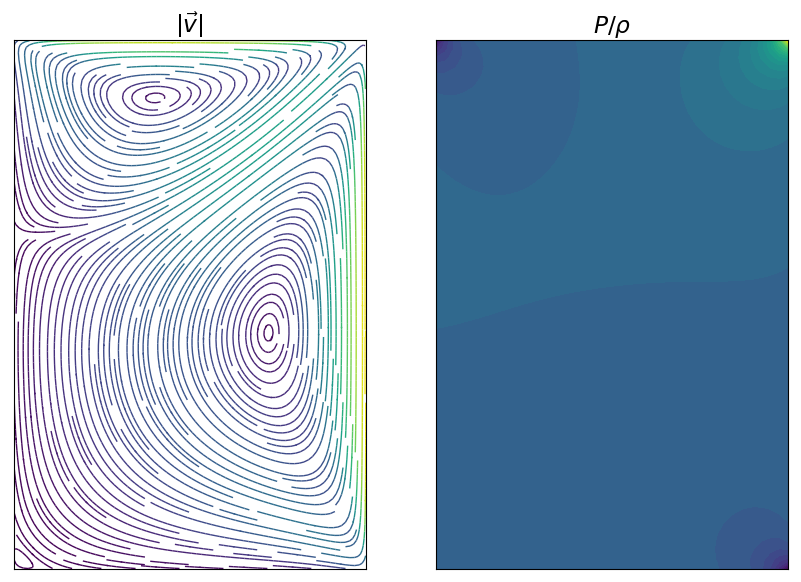

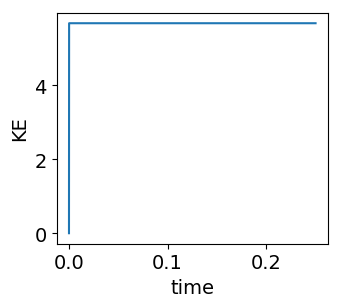

In [36]:
import PyPlot; plt=PyPlot;

X = repeat(repeat(x,1,1),  1,ny)
Y = repeat(repeat(y',1,1), nx,1)

plt.rc("font", size=14)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))

ax1.set_aspect("equal", adjustable="box")
ax1.streamplot(collect(x),collect(y),U',V', density=2.5, linewidth=1, arrowsize=0.001, color=velmag')
ax1.set_title(raw"$|\vec{v}|$")
ax1.set_xlim([0,Lx])
ax1.set_ylim([0,Ly])
ax1.set_xticks([])
ax1.set_yticks([]);

ax2.set_aspect("equal", adjustable="box")
ax2.contourf(X,Y,P,40)
ax2.set_title(raw"$P/\rho$")
ax2.set_xlim([0,Lx])
ax2.set_ylim([0,Ly])
ax2.set_xticks([])
ax2.set_yticks([]);

plt.figure(figsize=(3.5,3))
plt.plot(times,ke)
plt.xlabel("time")
plt.ylabel("KE");